<a href="https://colab.research.google.com/github/heinrych/lia1-2023-1/blob/main/Entregas%20-%20Heinrych%20Gomes/Entrega%206%20-%20Aula02-FastIA_Heinrych_Matheus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

#Obtendo os dados

In [4]:
ims = search_images_ddg('grizzly bear')
len(ims)

200

In [5]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']


In [6]:
import shutil

# Verifica se o diretório "bears" existe
if path.exists():
    # Exclui o diretório "bears" e todo o seu conteúdo
    shutil.rmtree(path)

In [7]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

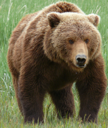

In [8]:
im = Image.open(dest)
im.to_thumb(128,128)

In [9]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [10]:
import time

bear_types = 'grizzly','black','teddy'
path = Path('bears')

if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        print(f'{o} bear, {dest}')
        results = search_images_ddg(f'{o} bear')
        time.sleep(2)
        try:
          for i in range(len(results)):
            download_url(results[i], dest)
        except:
          print("Erro")

grizzly bear, bears/grizzly


Erro
black bear, bears/black


Erro
teddy bear, bears/teddy


Erro


In [11]:
fns = get_image_files(path)
fns

(#127) [Path('bears/grizzly/grizzly.jpg'),Path('bears/grizzly/Black1792.JPG'),Path('bears/grizzly/Grizzly-Bears-animals-13128571-1024-768.jpg'),Path('bears/grizzly/Grizzly_Bear_In_Alaska_600.jpg'),Path('bears/grizzly/env-grizzly-bear.jpg'),Path('bears/grizzly/Canadian-Grizzly-Bear.jpg'),Path('bears/grizzly/30094-bears-nature-animals-Grizzly_bear-Grizzly_Bears.jpg'),Path('bears/grizzly/July-21-Grizzly-cub.jpg'),Path('bears/grizzly/Grizzly+Bear1.jpg'),Path('bears/grizzly/what-do-grizzly-bears-eat1.jpg')...]

In [12]:
failed = verify_images(fns)
failed
     

(#6) [Path('bears/grizzly/01grizzlydelisting.ngsversion.1457364600397.adapt.1900.1.jpg'),Path('bears/black/bk7cmlbczen61.jpg'),Path('bears/black/BlackBear200905.jpg'),Path('bears/black/black-bear-cub-wallpaper-1280x960-0001.jpg'),Path('bears/black/j93dxph482z51.jpg'),Path('bears/black/DSC0901-1.jpg')]

In [13]:
failed.map(Path.unlink);

In [14]:
doc(verify_images)

verify_images(fns)
Find images in `fns` that can't be opened

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


## Divisão dos dados para o treinamento


In [15]:
from pathlib import Path

path = Path('bears')
# if not path.exists():
#     path.mkdir()


In [16]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [17]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [18]:
dls = bears.dataloaders(path)

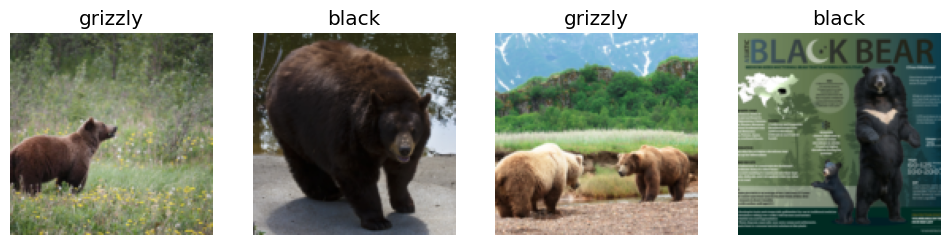

In [19]:
dls.valid.show_batch(max_n=4, nrows=1)

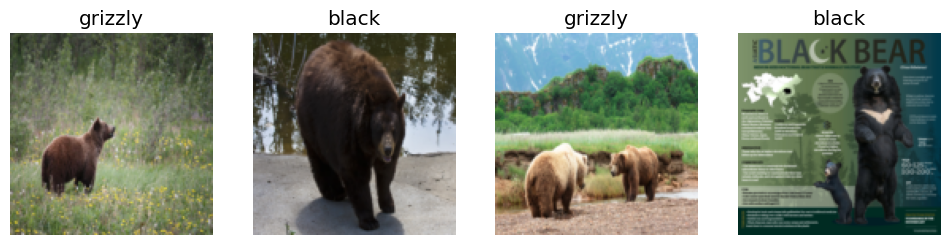

In [20]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

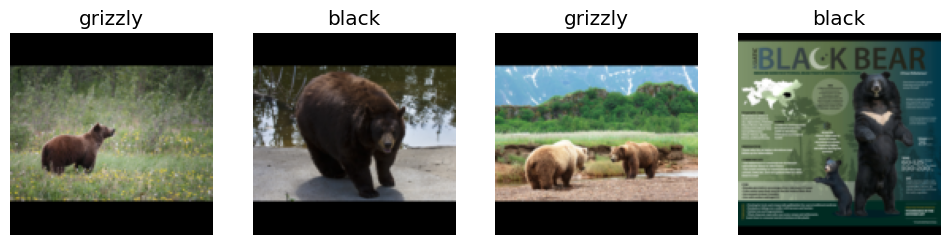

In [21]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)


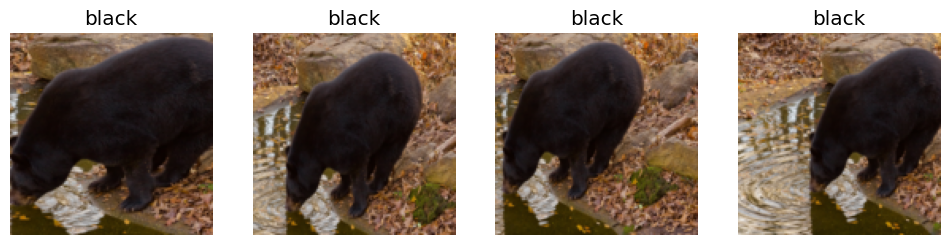

In [22]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Aumentando os dados, via perspectiva

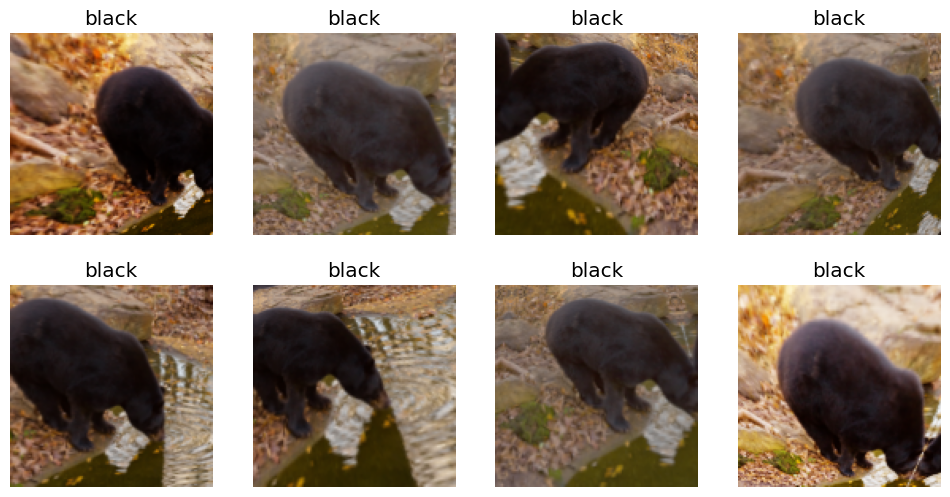

In [23]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Treinando o modelo, e limpando o dataset

In [24]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [25]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 111MB/s]


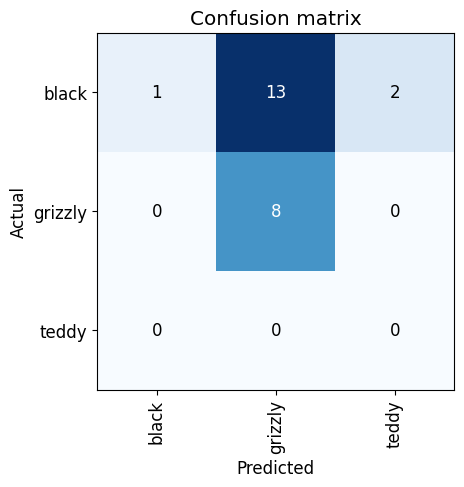

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

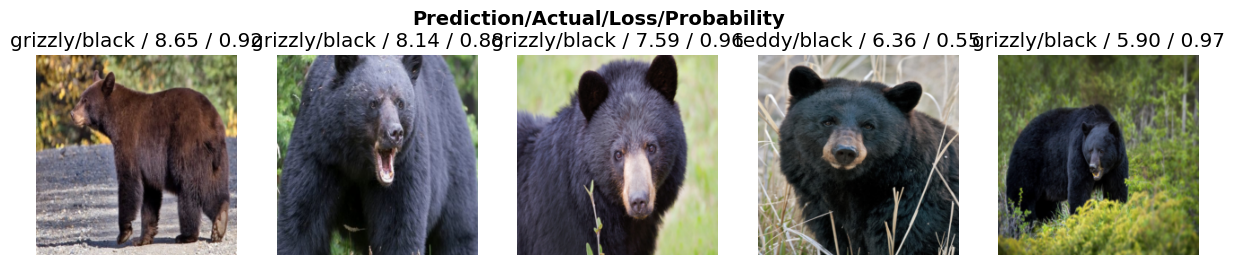

In [27]:
interp.plot_top_losses(5, nrows=1)

In [28]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [29]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [30]:
learn.export()

In [31]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [32]:
learn_inf = load_learner(path/'export.pkl')

In [33]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([7.8502e-07, 9.9068e-01, 9.3232e-03]))

In [34]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

### Creating a Notebook App from the Model

In [35]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [36]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [37]:
img = PILImage.create(btn_upload.data[-1])

In [38]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [39]:
pred,pred_idx,probs = learn_inf.predict(img)

In [40]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9907')

In [41]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [42]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [43]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [44]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

## Questionnaire

1. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.

**Resposta**: O modelo de classificação de ursos pode ter problemas em ambientes diferentes dos dados de treinamento, como áreas urbanas.

1. Where do text models currently have a major deficiency?
**Resposta**: contexto e raciocínio com senso comum.

1. What are possible negative societal implications of text generation models?
**Resposta**: supervisão humana é uma boa alternativa

1. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?
**Resposta**: é eficiente em dados tabulares com relações complexas e padrões não-lineares.

1. What kind of tabular data is deep learning particularly good at?
**Resposta**: problemas de interpretabilidade.

1. What's a key downside of directly using a deep learning model for recommendation systems?
**Resposta**: se aplicam à criação e melhoria de sistemas 

1. What are the steps of the Drivetrain Approach?
**Resposta**: Coletar dados, treinar um modelo inicial, analisar e ajustar 

1. How do the steps of the Drivetrain Approach map to a recommendation system?
**Resposta**: Melhorar o sistema de recomendação, eu acho.

1. Create an image recognition model using data you curate, and deploy it on the web.
**Resposta**: Não faço ideia como implata na web.

1. What is `DataLoaders`?
**Resposta**: lida com o carregamento e pré-processamento de dados para treinamento de modelos

1. What four things do we need to tell fastai to create `DataLoaders`?
**Resposta**: fornecer dados, um tipo de bloco, um tipo de splitter e transformações se for necessario

1. What does the `splitter` parameter to `DataBlock` do?
**Resposta**: Dividir dados em  treinamento e validação 

1. How do we ensure a random split always gives the same validation set?
**Resposta**:  Podemos garantir que uma divisão aleatória sempre forneça o mesmo conjunto de validação

1. What letters are often used to signify the independent and dependent variables?
**Resposta**: "X" é frequentemente usado para a variável independente e "y" para a variável dependente

1. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?
**Resposta**:  Crop corta a imagem, pad adiciona espaço em branco e squish distorce a imagem; Não sei, acho que depende da situação.

1. What is data augmentation? Why is it needed?
**Resposta**: É a técnica de modificar os dados de treinamento gerando versões alteradas

1. What is the difference between `item_tfms` and `batch_tfms`?
**Resposta**:  "item_tfms" são transformações aplicadas a cada item individualmente, enquanto "batch_tfms" são aplicadas ao conjunto de dados em lote

1. What is a confusion matrix?
**Resposta**: É uma matriz que mostra a contagem de previsões corretas e incorretas, de modo que fica mais facil identificar os erros e acertos e onde está o overfiting

1. What does `export` save?
**Resposta**: salva o modelo treinado 

1. What is it called when we use a model for getting predictions, instead of training?
**Resposta**: Quando usamos um modelo para fazer previsões, em vez de treiná-lo, estamos realizando a inferência.

1. What are IPython widgets?
**Resposta**: São recursos interativos do IPython que permitem a criação de controles como botões e barras de rolagem para interagir com o código

1. When might you want to use CPU for deployment? When might GPU be better?
**Resposta**: ser usada para implantação quando o modelo é pequeno ou a carga de trabalho é leve; a GPU é melhor para cálculos intensivos 

1. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?
**Resposta**: servidor pode ter latência, dependência de conectividade e custos de infraestrutura

1. What are three examples of problems that could occur when rolling out a bear warning system in practice?
**Resposta**:  problemas incluem falsos positivos, falhas na detecção de certos tipos de ursos

1. What is "out-of-domain data"?
**Resposta**: Refere-se a dados que são significativamente diferentes dos dados de treinamento do modelo

1. What is "domain shift"?
**Resposta**:  É a diferença entre os dados de treinamento e os dados do ambiente real 

1. What are the three steps in the deployment process?
**Resposta**: Os três passos são: preparar o modelo para implantação, configurar a infraestrutura necessária e disponibilizar o modelo para uso em produção.


### Further Research

1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?
1. For a project you're interested in applying deep learning to, consider the thought experiment "What would happen if it went really, really well?"
1. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.